## Objectives
* Design a pipeline of analyses for comparing regulatory networks between two species, where vertices are genes and edges their interactions
* Run descriptive analyses about species network
* Assess similarity between networks


## Datasets

Networks of the mouse and plant were obtained from [The Network Data Repository](https://networkrepository.com). These were are the references:

* Plant dataset: [networkrepository.com/bio-grid-plant](https://networkrepository.com/bio-grid-plant.php)
* Mouse dataset: [networkrepository.com/bio-grid-mouse](https://networkrepository.com/bio-grid-mouse.php)


## Descriptive analyses

Python libraries and data files are loaded:

In [18]:
import copy
import networkx as nx
import numpy as np
from scipy.special import lambertw
from empiricaldist import Pmf 
import matplotlib.pyplot as plt


def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

with open('./bio-grid-plant/bio-grid-plant.edges', 'rb') as f:
    Gplant = nx.read_edgelist(f, nodetype=int, delimiter=',')

with open('./bio-grid-mouse/bio-grid-mouse.edges', 'rb') as f:
    Gmouse = nx.read_edgelist(f, nodetype=int, delimiter=',')


# dictionary with metadata
meta = {
    0 : ['Plant', Gplant],
    1 : ['Mouse', Gmouse]
}

/Users/ulises/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


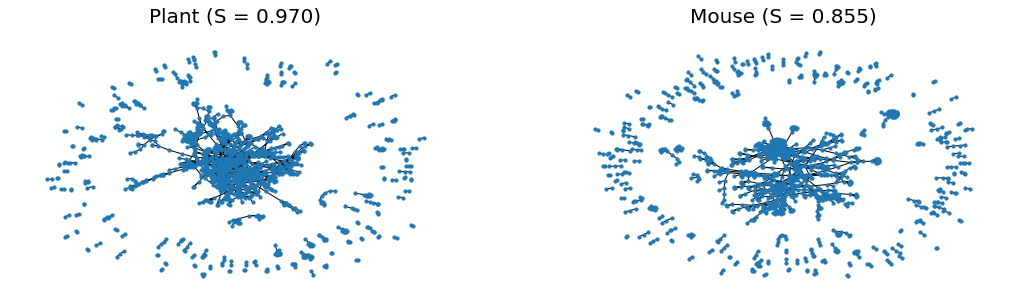

In [20]:

f,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
for i,info in meta.items():
    title,G = info

    mydegree = degrees(G)
    c = sum(mydegree)/len(mydegree)
    S = 1 + lambertw(-c*np.exp(-c))/c

    nx.draw(G, node_color = 'C0', with_labels = False, node_size = 10, ax = axes[i])
    axes[i].set_title("%s (S = %.3f)"  % (title, S), fontsize = 20)


### Distribution of degrees per node

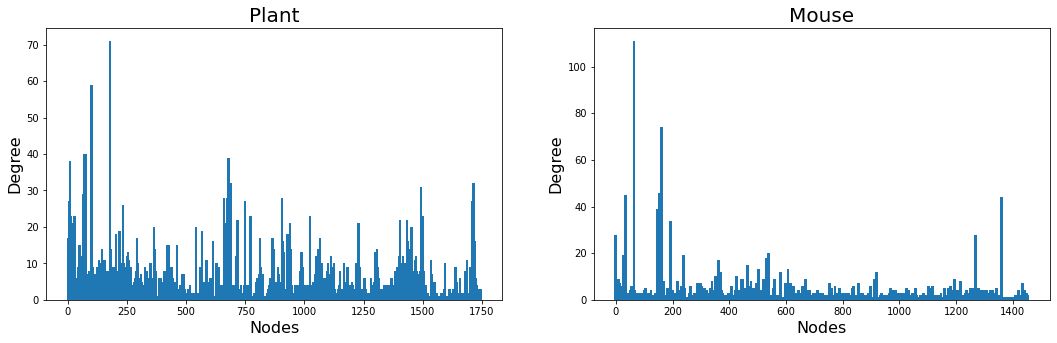

In [2]:
f,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
for i,info in meta.items():

    title,G = info

    degree_sequence = [(n,d) for n,d in G.degree()] 
    nodes = [ii[0] for ii in degree_sequence ]
    degree = [ii[1] for ii in degree_sequence]
    

    axes[i].bar(nodes, degree, width = 10)
    axes[i].set_title(title, fontsize = 20)
    axes[i].set_xlabel('Nodes', fontsize=16)
    axes[i].set_ylabel('Degree', fontsize=16)

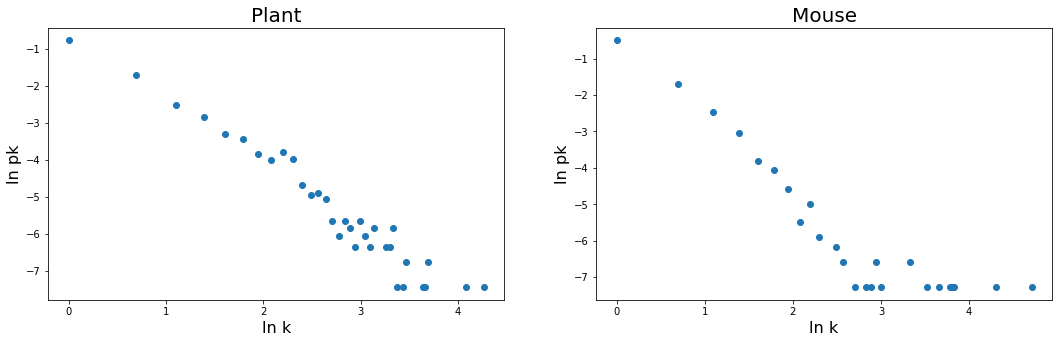

In [17]:


f,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
for i,info in meta.items():

    title,G = info

    pmf = Pmf.from_seq(degrees(G))

    k = [np.log(i) for i in pmf.index]
    pk = [np.log(i) for i in pmf]

    # plt.scatter( pk, k)

    axes[i].scatter(k, pk)
    axes[i].set_title(title, fontsize = 20)
    axes[i].set_xlabel('ln k', fontsize=16)
    axes[i].set_ylabel('ln pk', fontsize=16)    


### Katz centrality calculations

* Eigenvalues calculations

In [22]:

for i,info in meta.items():
    title,G = info
    eigenvalues = nx.linalg.adjacency_spectrum(G)
    max_eigenvalue = max(eigenvalues).real
    print("Max. eigenvalue for %s Adj. Matrix: %.3f" % (title, max_eigenvalue))
    meta[i] += [max_eigenvalue]

Max. eigenvalue for Plant Adj. Matrix: 20.436
Max. eigenvalue for Mouse Adj. Matrix: 13.086


*  Katz centrality calculation and node sorting according to this centrality

In [23]:
for i, info in meta.items():
    G = info[1]
    max_eigen = info[2]
    katz_cen = nx.katz_centrality(G, alpha = 1/max_eigen - 0.01 , beta = 1.0)
    # sort nodes by katz centrality
    sorted_list = sorted(katz_cen.items(), key=lambda x: x[1], reverse=True)
    meta[i] += [sorted_list]

/Users/ulises/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


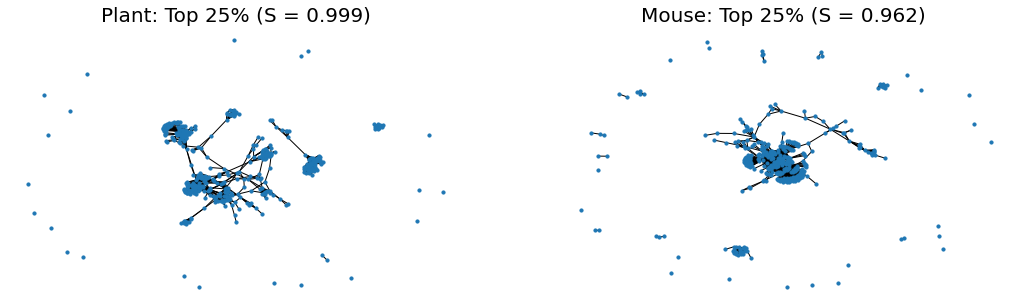

In [25]:
f,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
for i, info in meta.items():

    title = info[0]
    G = info[1]
    sort_list = info[3]
    
    sort_nodes = [i for i,_ in sort_list ]
    first_quartile_nodes = sort_nodes[: int( (len(sort_nodes) + 1)/4 ) ]

    G_tmp = copy.deepcopy(G)

    for node in G:
        if not (node in first_quartile_nodes):
            G_tmp.remove_node(node)
    
    mydegree = degrees(G_tmp)
    c = sum(mydegree)/len(mydegree)
    S = 1 + lambertw(-c*np.exp(-c))/c

    nx.draw(G_tmp, node_color = 'C0', with_labels = False, node_size = 10, ax = axes[i])
    axes[i].set_title( "%s: Top 25%% (S = %.3f)" % (title, S), fontsize = 20)


### Similarity measure

Graph edit distance is used to measure the number of changes on nodes or edges to make two graphs isomorphic [(Abu-Aisheh et al. 2015)](https://hal.archives-ouvertes.fr/hal-01168816/document). This distance will be recorded while the number of nodes are reduced in function of smaller Katz centrality values

In [27]:
Gplant = meta[0][1]
sorted_nodes_plant = [i for i,_ in  meta[0][3]]

Gmouse = meta[1][1]
sorted_nodes_mouse = [i for i,_ in  meta[1][3]]

graph_distance = []
top_rank = []

for i in range(1, 25):

    f = (i/100)
    print("GED at %s %% top nodes" % f)

    # Plant trimming
    plant_ranked = sorted_nodes_plant[: int( (len(sorted_nodes_plant) + 1)*f ) ]
    G_plant_tmp  = copy.deepcopy(Gplant)

    for node in Gplant:
        if not (node in plant_ranked):
            G_plant_tmp.remove_node(node)

    # Mouse trimming
    mouse_ranked = sorted_nodes_mouse[: int( (len(sorted_nodes_mouse) + 1)*f ) ]
    G_mouse_tmp  = copy.deepcopy(Gmouse)


    for node in Gmouse:
        if not (node in mouse_ranked):
            G_mouse_tmp.remove_node(node)

    tmp_dist = nx.graph_edit_distance(G_plant_tmp, G_mouse_tmp, timeout = 6)

    graph_distance.append(tmp_dist)
    top_rank.append(i/100)


GED at 0.01 % top nodes
GED at 0.02 % top nodes
GED at 0.03 % top nodes
GED at 0.04 % top nodes
GED at 0.05 % top nodes
GED at 0.06 % top nodes
GED at 0.07 % top nodes
GED at 0.08 % top nodes
GED at 0.09 % top nodes
GED at 0.1 % top nodes
GED at 0.11 % top nodes
GED at 0.12 % top nodes
GED at 0.13 % top nodes
GED at 0.14 % top nodes
GED at 0.15 % top nodes
GED at 0.16 % top nodes
GED at 0.17 % top nodes
GED at 0.18 % top nodes
GED at 0.19 % top nodes
GED at 0.2 % top nodes
GED at 0.21 % top nodes
GED at 0.22 % top nodes
GED at 0.23 % top nodes
GED at 0.24 % top nodes


Text(0, 0.5, 'Distance')

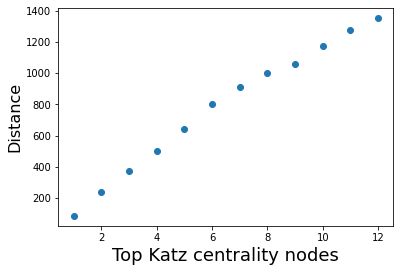

In [28]:
plt.scatter([i*100 for i in top_rank], graph_distance)
plt.xlabel('Top Katz centrality nodes', fontsize=18)
plt.ylabel('Distance', fontsize=16)